In [12]:
!pip show classiq

Name: classiq
Version: 0.76.0
Summary: Classiq's Python SDK for quantum computing
Home-page: 
Author: Classiq Technologies
Author-email: support@classiq.io
License: Proprietary
Location: /classiq-venv
Requires: black, ConfigArgParse, httpx, keyring, matplotlib, networkx, numexpr, numpy, packaging, pandas, plotly, pydantic, pydantic-settings, Pyomo, scipy, sympy, tabulate, tqdm, zstandard
Required-by: 


In [11]:
from pyscf import gto, scf, mcscf, ao2mo, tools
from pyscf.mcscf import avas
from openfermion import jordan_wigner, save_operator, FermionOperator, QubitOperator
from classiq import synthesis, execution
from typing import List
from classiq.execution import (
    ClassiqBackendPreferences,
    ExecutionPreferences,
    set_quantum_program_execution_preferences,
)
import matplotlib.pyplot as plt

AttributeError: partially initialized module 'classiq' has no attribute 'interface' (most likely due to a circular import)

# Preprocessing

This part is already taken into account another DFT preprocessing where the geometry optimization is realized using Quantum Espresso. Below, we have the optimized coordinates of the atoms without the bottom layer (originally there were 27 Cu atoms, and here we are taking into account only the upper 18). With these coordinates, it is possible to define the molecule using PySCF and perform HF simulation.

In [ ]:
coords = [
    # Middle layer Cu (z ≈17 A)
    ('Cu', [-0.0395020103, 1.4820503611, 17.1143137893]),
    ('Cu', [2.4994443187, 1.4824792111, 17.1149016882]),
    ('Cu', [5.0501143692, 1.4808569247, 17.1207591325]),
    ('Cu', [1.2307216878, 3.6822830061, 17.0781231482]),
    ('Cu', [3.7810206409, 3.7028835438, 17.0938506694]),
    ('Cu', [6.3307687416, 3.7046367936, 17.0970745783]),
    ('Cu', [2.5030214963, 5.8956616297, 17.0989339276]),
    ('Cu', [5.0714983075, 5.8828658294, 17.0761500349]),
    ('Cu', [7.6304264753, 5.9039376317, 17.1077863480]),

    # Top layer Cu (z ≈19 A)
    ('Cu', [-0.0859000009, 0.0037967297, 19.1531953408]),
    ('Cu', [2.5526884077, -0.0017635921, 19.1368324652]),
    ('Cu', [5.0666730153, 0.0078287410, 19.1573385137]),
    ('Cu', [1.2221691764, 2.2852913305, 19.1351989591]),
    ('Cu', [3.7949069965, 2.2438195621, 19.1469027886]),
    ('Cu', [6.3309339951, 2.2370558840, 19.1474912435]),
    ('Cu', [2.4714071248, 4.4276206962, 19.1376209578]),
    ('Cu', [5.0576842912, 4.3865808467, 19.1200076634]),
    ('Cu', [7.6311490771, 4.4237624444, 19.1426687590]),

    # Adsorbed O₂⁻
    ('O', [0.5749056752, -0.1223946577, 20.9180568583]),
    ('O', [1.9047215770, 0.1991137313, 20.9029578000])
]

Definition of the basis used in the DFT calculations.

In [3]:
#Here I'm defining the Gaussian basis. This is one of the pre processing steps where I'm unsure how to reproduce from the paper.
basis = {
    'Cu': gto.basis.parse('''
Cu    S
0.500000   1.0
0.250000   1.0
Cu    D
5.000000   1.0
2.500000   1.0
Cu    P
1.000000   1.0
'''),    
    'O': gto.basis.parse('''
O    S
2.941249   1.0
O    P
2.941249   1.0
''')
}

ecp = {
    'Cu': gto.basis.parse_ecp('''
Cu nelec 28
Cu ul
1      30.00000      10.000000
3      20.000000    200.000000
2      15.000000    -50.000000
''')
}

In [2]:
!pip install pyscf

  error: subprocess-exited-with-error
  
  × Building wheel for pyscf (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [76 lines of output]
      C:\Users\Guy Sella\AppData\Local\Temp\pip-build-env-8kkoena7\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ***********************************************

     ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
     -- ------------------------------------- 0.5/10.1 MB 4.2 MB/s eta 0:00:03
     ----------- ---------------------------- 2.9/10.1 MB 9.3 MB/s eta 0:00:01
     ---------------------- ----------------- 5.8/10.1 MB 11.7 MB/s eta 0:00:01
     ------------------------------ --------- 7.6/10.1 MB 11.5 MB/s eta 0:00:01
     --------------------------------------- 10.1/10.1 MB 10.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pyscf


Definition of the molecule using the coordinates and basis defined before

In [21]:
# Defining the molecule
mol = gto.M(
    atom=coords,
    basis=basis,
    ecp=ecp,
    spin=0,
    charge=-0,
    verbose=4
)

System: uname_result(system='Linux', node='Alexandre', release='5.15.167.4-microsoft-standard-WSL2', version='#1 SMP Tue Nov 5 00:21:55 UTC 2024', machine='x86_64')  Threads 12
Python 3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]
numpy 1.26.4  scipy 1.15.2  h5py 3.13.0
Date: Tue Mar 25 15:40:42 2025
PySCF version 2.8.0
PySCF path  /home/alexandre/Classiq_linux/venv/lib/python3.12/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 20
[INPUT] num. electrons = 34
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 Cu    -0.039502010300   1.482050361100  17.114313789300 AA   -0.074647980837   2.800669285292  32.341365871644 Bohr   0.0
[INPUT]  2 Cu     2.499444318700   1.482479211100  17.114901688200 AA    4.723265225943   2.80147969

HF Calculation

In [22]:
# There are several ways of doing these HF calculations. I asked chatGPT to indicate me the best ways, and it seems like ROHF and UKS are the most prominent for this case.
rhf = scf.ROHF(mol)
rhf.kernel() 
#mf = scf.UKS(mol)
#mf.xc = 'SCAN'  
#mf.mo_coeff = rhf.mo_coeff
#mf.conv_tol = 1e-8  
#mf.diis_space = 10 
#mf.level_shift = 0.5 
#mf.max_cycle = 500  
#mf.kernel()



******** <class 'pyscf.scf.rohf.ROHF'> ********
method = ROHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpvurgpevv
max_memory 4000 MB (current use 1330 MB)
num. doubly occ = 17  num. singly occ = 0
Set gradient conv threshold to 3.16228e-05
init E= -59.8736785685392
  HOMO = -0.912500345854949  LUMO = -0.908831752126338
cycle= 1 E= -75.5088806770085  delta_E= -15.6  |g|= 1.67  |ddm|= 3.83
  HOMO = 0.693817227408415  LUMO = 0.809807660908935
cycle= 2 E= -51.6391679192106  delta_E= 23.9  |g|= 2.33  |ddm|= 6.07
  HOMO = 0.155643224835419  LUMO = 0.170800160680821
cycle= 3 E= -77.4008559625787  delta_E= -25.8  |g|= 1.46  |ddm|= 5.68
  HOMO = 0.165630928842902  LUMO = 0.195624409878126
cycle= 4 E= -64.4035515705062  delta_E=   13  |g|= 1.67 

-88.89236021909662

AVAS calculation

In [23]:
# Originally in the paper they use threshold = 0.1. For some reason they end up with 2/2, 4/6 or 6/10 active spaces, and I don't. Here I'm only showcasing the threshold = 0.55 so I can speedup some calculations.
# If you set threshold = 0.1, it will take quite some time to synthesize and run the circuit, because you will have a really big ansatz with more than 200 parameters.
n_orb, n_elec, mo_coeff = avas.avas(
    rhf,
    aolabels=['O 2p', 'Cu 3d'],
    threshold=0.55,
    openshell_option=2,
    canonicalize=True
)


******** AVAS flags ********
aolabels = ['O 2p', 'Cu 3d']
ncore = 0
minao = minao
threshold = 0.55
with_iao = False
openshell_option = 2
canonicalize = True

** AVAS **
  Total number of HF MOs  is equal to    170
  Number of occupied HF MOs is equal to  17
reference AO indices for minao ['O 2p', 'Cu 3d']:
 [272 273 274 277 278 279]
Option 2: threshold 0.55
Active from occupied = 2 , eig [0.58103825 0.5884506 ]
Inactive from occupied = 15
Active from unoccupied = 1 , eig [0.56330152]
Inactive from unoccupied = 152
Dimensions of active 3
# of alpha electrons 2
# of beta electrons 2


In [24]:
mc = mcscf.CASSCF(rhf, n_orb, n_elec)
mc.mo_coeff = mo_coeff  # Critical: Use AVAS-sorted orbitals
mc.fcisolver.conv_tol = 1e-6
mc.kernel()


******** <class 'pyscf.mcscf.mc1step.CASSCF'> ********
CAS (2e+2e, 3o), ncore = 15, nvir = 152
max_cycle_macro = 50
max_cycle_micro = 4
conv_tol = 1e-07
conv_tol_grad = None
orbital rotation max_stepsize = 0.02
orbital rotation threshold for CI restart = 0.01
augmented hessian ah_max_cycle = 30
augmented hessian ah_conv_tol = 1e-12
augmented hessian ah_linear dependence = 1e-14
augmented hessian ah_level shift = 1e-08
augmented hessian ah_start_tol = 2.5
augmented hessian ah_start_cycle = 3
augmented hessian ah_grad_trust_region = 3
kf_trust_region = 3
kf_interval = 4
ci_response_space = 4
ci_grad_trust_region = 3
with_dep4 0
natorb = False
canonicalization = True
sorting_mo_energy = False
ao2mo_level = 2
chkfile = /tmp/tmpvurgpevv
max_memory 4000 MB (current use 1378 MB)
internal_rotation = False
******** <class 'pyscf.fci.direct_spin1.FCISolver'> ********
max. cycles = 50
conv_tol = 1e-06
davidson only = False
linear dependence = 1e-12
level shift = 0.001
max iter space = 12
max_mem

(-88.98726604086636,
 -29.00224377016805,
 FCIvector([[-0.74120236, -0.01381171,  0.01605138],
            [-0.01381171,  0.67031134,  0.01420879],
            [ 0.01605138,  0.01420879,  0.00108182]]),
 array([[ 1.29424337e-05, -9.49922461e-02, -2.79717915e-02, ...,
          1.20700451e-06,  1.87861093e-05, -4.80911031e-06],
        [-3.75239469e-08, -3.48540444e-04, -1.60784996e-03, ...,
         -7.14472655e-06,  7.65212404e-06, -4.59708873e-06],
        [-1.75285013e-06,  1.66799814e-03, -2.02848273e-03, ...,
         -1.62134534e-06,  2.20747559e-06, -4.89773127e-06],
        ...,
        [-5.27809853e-04, -5.45132285e-02, -1.85406595e-01, ...,
          1.41943224e-06, -2.07561148e-07, -1.03135438e-06],
        [-1.29719894e-04, -1.18652904e-02, -4.30690266e-02, ...,
         -4.34753201e-07,  3.58588433e-07,  1.32552409e-07],
        [ 6.98977257e-05,  1.57594834e-02,  2.41496130e-02, ...,
          9.39093956e-07,  6.03416606e-07,  1.20081524e-06]]),
 array([-9.77455715, -0.23

Evaluation of the coefficients of the second quantization form.

In [25]:
# These are the coefficients of the a,a.dag terms in second quantization form
h1e, energy_core = mc.get_h1eff()
h2_compressed = mc.get_h2eff() 
h2 = ao2mo.restore(1, h2_compressed, n_orb)
# This is just a sanity check:
h2.shape

(3, 3, 3, 3)

# OpenFermion and PySCF

Here, we can use the results obtained together with OpenFermion to build the Hamiltonian of the problem using jordan-wigner over the second quantization hamiltonian.

In [ ]:
ham_fermionic = FermionOperator()

# Add core energy (constant term)
ham_fermionic += FermionOperator.identity() * energy_core

# One-body terms (include both α and β spins)
for p in range(mc.ncas):
    for q in range(mc.ncas):
        coeff = h1e[p, q]
        # α-spin terms (indices 2p, 2q)
        ham_fermionic += FermionOperator(f"{2*p}^ {2*q}", coeff)
        # β-spin terms (indices 2p+1, 2q+1)
        ham_fermionic += FermionOperator(f"{2*p+1}^ {2*q+1}", coeff)

for p in range(mc.ncas):
    for q in range(mc.ncas):
        for r in range(mc.ncas):
            for s in range(mc.ncas):
                coeff = 0.5 * h2[p, q, r, s]
                for sigma in [0, 1]:    # 0 = alpha, 1 = beta
                    for tau in [0, 1]:
                        ham_fermionic += FermionOperator(
                            f"{2*p + sigma}^ {2*q + tau}^ "
                            f"{2*r + tau} {2*s + sigma}", 
                            coeff
                        )

# Jordan-Wigner transformation
qubit_hamiltonian = jordan_wigner(ham_fermionic)
qubit_hamiltonian.compress(abs_tol=1e-12)

print(f"Qubit Hamiltonian has {len(qubit_hamiltonian.terms)} terms")
print("Hamiltonian terms:")
print(*list(qubit_hamiltonian.terms.items()), sep="\n")

Qubit Hamiltonian has 136 terms
Hamiltonian terms:
((), -81.99290600400164)
(((0, 'Z'),), 6.630701450989928)
(((1, 'Z'),), 6.630701450989928)
(((0, 'Y'), (1, 'Z'), (2, 'Y')), -0.10092683451828827)
(((0, 'X'), (1, 'Z'), (2, 'X')), -0.10092683451828827)
(((1, 'Y'), (2, 'Z'), (3, 'Y')), -0.10092683451828827)
(((1, 'X'), (2, 'Z'), (3, 'X')), -0.10092683451828827)
(((0, 'Y'), (1, 'Z'), (2, 'Z'), (3, 'Z'), (4, 'Y')), -0.10731111783075256)
(((0, 'X'), (1, 'Z'), (2, 'Z'), (3, 'Z'), (4, 'X')), -0.10731111783075256)
(((1, 'Y'), (2, 'Z'), (3, 'Z'), (4, 'Z'), (5, 'Y')), -0.10731111783075256)
(((1, 'X'), (2, 'Z'), (3, 'Z'), (4, 'Z'), (5, 'X')), -0.10731111783075256)
(((2, 'Z'),), 1.780799915494276)
(((3, 'Z'),), 1.780799915494276)
(((2, 'Y'), (3, 'Z'), (4, 'Y')), -0.0024386731168061886)
(((2, 'X'), (3, 'Z'), (4, 'X')), -0.0024386731168061886)
(((3, 'Y'), (4, 'Z'), (5, 'Y')), -0.0024386731168061886)
(((3, 'X'), (4, 'Z'), (5, 'X')), -0.0024386731168061886)
(((4, 'Z'),), 1.7720653817371543)
(((5, 'Z')

### Performing Jordan-Wigner transformation to obtain the qubit Hamiltonian:

In [27]:
pauli_char_to_obj = {"I": Pauli.I, "Z": Pauli.Z, "X": Pauli.X, "Y": Pauli.Y}


def qubit_op_to_hamiltonian(qbit_op, n_qubits):
    """Convert OpenFermion QubitOperator to list of PauliTerm"""
    hamiltonian = []

    for term, coeff in qbit_op.terms.items():

        pauli_list = [Pauli.I] * n_qubits  # Default to identity

        for qubit, pauli in term:
            pauli_list[qubit] = pauli_char_to_obj[pauli]  # Replace with correct Pauli

        # Append list-style Pauli term
        hamiltonian.append(PauliTerm(pauli=pauli_list[::-1], coefficient=coeff))

    return hamiltonian

# This is the hamiltonian of the system after performing jordan-wigner:
measured_hamiltonian = qubit_op_to_hamiltonian(qubit_hamiltonian, 2*n_orb)

### Evaluating the Hartree-Fock state

In [28]:
# If changing threshold, these lists needs to be changed according to the alpha and beta electrons occupation
alpha_occ = [1.0, 1.0, 0.0]  # 2 alpha-electrons in first 2 orbitals
beta_occ = [1.0, 0.0, 0.0]   # 1 beta-electrons in first orbital


alpha_occupied = [i for i, occ in enumerate(alpha_occ) if occ > 0.5]
beta_occupied = [i + n_orb for i, occ in enumerate(beta_occ) if occ > 0.5]
occupied_spin_orbitals = alpha_occupied + beta_occupied 

# Step 2: Build the HF state bitstring
n_qubits = 2 * n_orb
hf_bitstring = ['0'] * n_qubits
for idx in occupied_spin_orbitals:
    hf_bitstring[idx] = '1'
hf_bitstring = ''.join(hf_bitstring[::-1])  # OpenFermion uses little-endian

print(f"HF state: |{hf_bitstring}>")

HF state: |001011>


### Evaluating the generator for the UCCSD ansatz, $\textit{i.e.}$, the operators that generate a single or double excitation of the electrons.

In [29]:
# If changing threshold, these parameters also need to be changed
n_elec_alpha = 2
n_elec_beta = 1 
 
occupied = alpha_occupied + beta_occupied

# Virtual spin orbitals (unoccupied in HF)
virtual = [i for i in range(2*n_orb) if i not in occupied]


def generate_uccsd_excitations(occupied, virtual):
    singles = []
    doubles = []
    
    # Single excitations (i -> a)
    for i in occupied:
        for a in virtual:
            singles.append((i, a))
    
    # Double excitations (i,j -> a,b)
    for i in occupied:
        for j in occupied:
            if j <= i:
                continue  # Avoid duplicates
            for a in virtual:
                for b in virtual:
                    if b <= a:
                        continue  # Avoid duplicates
                    doubles.append((i, j, a, b))
    
    return singles, doubles

singles, doubles = generate_uccsd_excitations(occupied, virtual)

### Associating each group of generators with its own parameter in the VQE execution

In [ ]:
def build_uccsd_ansatz(singles, doubles):

    qubit_generator_singles = []
    qubit_generator_doubles = []
    # Add parameterized UCCSD excitations
    for idx, (i, a) in enumerate(singles):
        generator = FermionOperator(f"{a}^ {i}") - FermionOperator(f"{i}^ {a}")
        qubit_generator_singles.append(jordan_wigner(generator))
    
    for idx, (i, j, a, b) in enumerate(doubles):
        generator = FermionOperator(f"{a}^ {b}^ {j} {i}") - FermionOperator(f"{i}^ {j}^ {b} {a}")
        qubit_generator_doubles.append(jordan_wigner(generator))
    
    return qubit_generator_singles, qubit_generator_doubles
generator_list_singles, generator_list_doubles = build_uccsd_ansatz(singles,doubles)

def generate_pauli_terms_list(qubit_generators_singles: List[QubitOperator], qubit_generators_doubles: List[QubitOperator]) -> List[PauliTerm]:

    pauli_terms_groups = []
        
    # Process single excitation generators
    for generator in qubit_generators_singles:
        group = []
        for term, coeff in generator.terms.items():
            pauli_list = [Pauli.I] * n_qubits
            for (qubit_idx, pauli_char) in term:
                if pauli_char == 'X':
                    pauli_list[qubit_idx] = Pauli.X
                elif pauli_char == 'Y':
                    pauli_list[qubit_idx] = Pauli.Y
                elif pauli_char == 'Z':
                    pauli_list[qubit_idx] = Pauli.Z
            group.append(PauliTerm(pauli_list, coeff.imag))
        pauli_terms_groups.append(group)
    
    # Process double excitation generators
    for generator in qubit_generators_doubles:
        group = []
        for term, coeff in generator.terms.items():
            pauli_list = [Pauli.I] * n_qubits
            for (qubit_idx, pauli_char) in term:
                if pauli_char == 'X':
                    pauli_list[qubit_idx] = Pauli.X
                elif pauli_char == 'Y':
                    pauli_list[qubit_idx] = Pauli.Y
                elif pauli_char == 'Z':
                    pauli_list[qubit_idx] = Pauli.Z
            group.append(PauliTerm(pauli_list, coeff.imag))
        pauli_terms_groups.append(group)
    
    return pauli_terms_groups

In [ ]:
generators = generate_pauli_terms_list(generator_list_singles,generator_list_doubles)
n_params = len(generators)

18

### These are parameters for the quantum program, such as number of iterations, initial parameters and convergence tolerance.

In [32]:
hamiltonian_qmod = QConstant("hamiltonian_qmod", CArray[PauliTerm], measured_hamiltonian)
max_iter_qmod = QConstant("max_iter_qmod", CInt, 500)
initial_params_qmod = QConstant("initial_params_qmod", CArray[CInt], [0] * n_params)
tol_qmod = QConstant("tol_qmod", CReal, 0.001)

### Quantum programs with Classiq: The main function.

In [ ]:
@qfunc(generative=True)
def main(params: CArray[CReal, n_params], qbv:Output[QArray[QBit]]):
    allocate(n_qubits,qbv)
    # Hartree-Fock initial state preparation, executed using the HF bitstring.
    i = 0
    for idx in hf_bitstring:
        if idx=='1':
            X(qbv[i])
        i+=1
    i=0
    # Execution of the Trotter-Suzuki for each parameter, since the generators were divided into groups of the same parameter, you can execute an instance of the Trotter-Suzuki expansion for every parameter.
    for ham in generators:
        suzuki_trotter(
            ham,
            evolution_coefficient=-params[i],
            order=1,
            repetitions=1,
            qbv=qbv,
        )
        i+=1

### Classical iteration of the quantum program: cmain function

In [ ]:
# Here we are defining some characteristics of the classical optimization routine, such as the initial parameter that are associated to each excitation group of generators, optimization method (e.g. COBYLA or ADAM), number of iterations, and tolerance.
@cfunc
def cmain() -> None:
    res = vqe(
        hamiltonian_qmod,
        False,
        initial_params_qmod,
        optimizer=Optimizer.COBYLA,
        max_iteration=max_iter_qmod,
        tolerance=tol_qmod,
        step_size=0,
        skip_compute_variance=False,
        alpha_cvar=1.0,
    )
    save({"result": res})

In [35]:
qmod = create_model(main, classical_execution_function=cmain, preferences=Preferences(timeout_seconds= 1000))
qprog = synthesize(qmod)

### Execution of the quantum program in the statevector simulator, by changing the `backend_name` one can execute it on different simulators or the available real hardware.

In [ ]:
#num_shots =1 because we are running on a statevector simulator, if using real hardware it is necessary to set more shots.
qprog = set_quantum_program_execution_preferences(
    qprog,
    preferences=ExecutionPreferences(
        num_shots=1,
        backend_preferences=ClassiqBackendPreferences(
            backend_name="simulator_statevector"
        ),
    ),
)
res = execute(qprog).result()

### Post processing: Classiq structures the output of the VQE execution in a dictionary, where you can plot the values of the different iterations and analyze the results.

optimizer result classiq: -91.42239304072238


Text(0.5, 1.0, 'VQE result for Cu O2-')

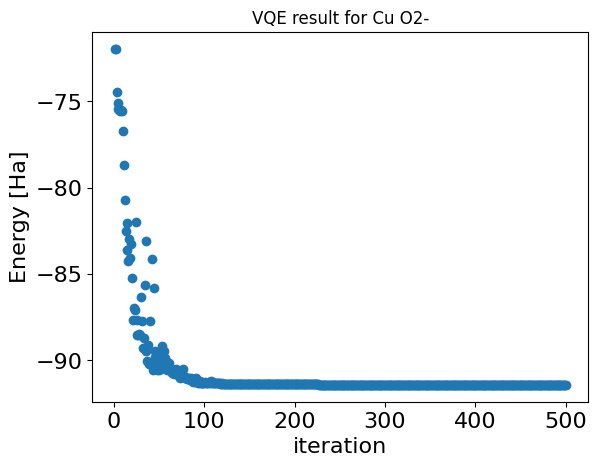

In [37]:
optimizer_res = res[0].value.energy
print(f"optimizer result classiq: {optimizer_res}")

vqe_results = {
    intermediate_result.iteration_number: intermediate_result.mean_all_solutions
    for intermediate_result in res[0].value.intermediate_results
}


plt.plot(vqe_results.keys(), vqe_results.values(), "o")
plt.ylabel("Energy [Ha]", fontsize=16)
plt.xlabel("iteration", fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.title("VQE result for Cu O2-")